<a href="https://colab.research.google.com/github/vladeviste/mat230/blob/main/phase_diagrams_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear phase diagram analysis

This notebook provides an interactive exploration of two-dimensional linear dynamical systems using phase diagrams, vector fields, and numerical solutions. Linear systems of the form $\dot{\mathbf{x}} = A\mathbf{x}$ are fundamental in mathematics, physics, and engineering, as they describe a wide range of phenomena including population dynamics, electrical circuits, and mechanical vibrations.

By visualizing trajectories, vector fields, and eigenvectors, we gain insight into the stability and qualitative behavior of solutions. The notebook combines analytical tools (such as eigenvalue analysis) with computational methods to deepen understanding and build intuition for linear systems and their phase portraits.

First read some libraries needed.


In [ ]:
import numpy as np # Numpy for numerical operations
import scipy as sp # SciPy for scientific computing
from pprint import pprint # Pretty-printing for better readability
import matplotlib.pyplot as plt # Plotting library
#%matplotlib inline # Inline plotting for Jupyter notebooks


We're looking at two-dimensional autonomous linear system of ordinary differential equations (ODEs) on the form:
$$
\frac{dx}{dt} = a x + b y \\[5mm]
\frac{dy}{dt} = c x + d y
$$

or
$$
\dot{\bf x}=A{\bf x}
$$
with
$$
A = \left[ \begin{matrix}
a & b \\
c & d
\end{matrix}\right]
$$

### Defining the right-hand side function
The function `rhs_2D` below defines the right-hand. It takes the current time `t`, the current position `pos` (a list or array with two elements, representing the variables $x$ and $y$), and a list of parameters `params` (corresponding to the coefficients $a$, $b$, $c$, and $d$). The function returns the derivatives $\frac{dx}{dt}$ and $\frac{dy}{dt}$ as a list. This function allows you to analyze how the system evolves over time for different parameter values. Notice how the function has default values.

We will use the following example:
$$
\begin{aligned}
\frac{dx}{dt} &=& x &+ y \\[3mm]
\frac{dy}{dt} &=& 4x &- 2y
\end{aligned}
$$
The parameters can easily be changed, and some exercises follows at the end.

> **Note:**
> Even though we're looking at autonomous systems here, i.e. the _A_ matrix is not time dependent, we do need to have _t_ as input to the function providing the right hand side in order to call the numerical solver we're going to use, _solve_ivp_.



In [ ]:
# This is a function that evaluates the right hand side of the 2D ODE, changing the parameters change the system.

def rhs_2D(t=0, pos=[0,0], params=[-1,0,1,0]): # Default!!! values for time, position and parameters
    """
    Defines the right-hand side of a 2D linear ODE system.

    Parameters
    ----------
    t : float, optional
        Time variable (not used in this linear system, included for compatibility).
    pos : list or array-like, optional
        Current position [x, y].
    params : list or array-like, optional
        System parameters [a, b, c, d] for the equations:
            dx/dt = a*x + b*y
            dy/dt = c*x + d*y

    Returns
    -------
    list
        Derivatives [dx/dt, dy/dt] at the given position.
    """
    x, y = pos # Unpack position into x and y
    a,b,c,d=params # Unpack parameters into a, b, c, d
    dxdt = a*x + b*y # Compute the derivative dx/dt
    dydt = c*x+ d*y # Compute the derivative dy/dt
    return [dxdt, dydt] # Return the derivatives as a list


### Exploring the Right-Hand Side Function

In the previous cell, we evaluated the right-hand side function `rhs_2D` for a specific set of parameters and initial conditions. This function is central to analyzing the dynamics of the 2D linear system, as it determines how the state of the system evolves over time.



In [ ]:
# Evaluate the right hand side by changing pos and params. Try a few different values of pos and params.
t=0
pos= [1,2] # Arbitrary choice. Generally is the representation on the intial condition
params= [1,1,4,-2] # Our example parameters

f_default = rhs_2D(t) # Using default pos and params
f_pos = rhs_2D(t, pos=pos) # Using specified pos and default params
f_params = rhs_2D(t, params=params) # Using specified params and default pos
f_both = rhs_2D(t, pos=pos, params=params) # Using specified pos and params
print(f'rhs_2D with default pos and params: {f_default}')
print(f'rhs_2D with pos={pos} and default params: {f_pos}')
print(f'rhs_2D with params={params} and default pos: {f_params}')
print(f'rhs_2D with pos={pos} and params={params}: {f_both}')

rhs_2D with default pos and params: [0, 0]
rhs_2D with pos=[1, 2] and default params: [-1, 1]
rhs_2D with params=[1, 1, 4, -2] and default pos: [0, 0]
rhs_2D with pos=[1, 2] and params=[1, 1, 4, -2]: [3, 0]


The vector $\mathbf{f}(\mathbf{x})$ at a point $\mathbf{x}$ represents the instantaneous rate of change of the system at that position. In the context of a differential equation $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x})$, this means that $\mathbf{f}(\mathbf{x})$ is tangent to the trajectory (solution curve) passing through $\mathbf{x}$. The direction and magnitude of $\mathbf{f}(\mathbf{x})$ indicate how the state $\mathbf{x}$ will evolve over an infinitesimal time interval, and the collection of these tangent vectors forms the vector field that governs the system's dynamics.

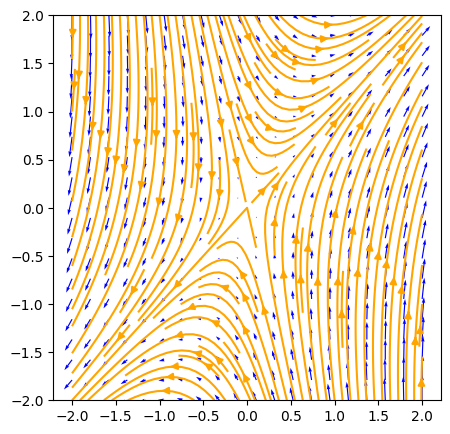

In [ ]:
# Create a grid for quiver plot
x = np.linspace(-2, 2, 20) #(start,stop,num=50)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

U = np.zeros_like(X) #creates an array U having the same dimentions as X, starts empty and then is filled with dx/dt
V = np.zeros_like(Y) #vertical component

params = [1,1,4,-2]

fig, ax = plt.subplots(figsize=(5,5)) #ax = axes (specific plot that you draw onto fig)
# Evaluate rhs_2D at each grid point
for i in range(X.shape[0]): #gives the number of rows
    for j in range(X.shape[1]): #gives the number of columns
        U[i, j], V[i, j] = rhs_2D(t=0, pos=[X[i, j], Y[i, j]], params=params)

ax.quiver(X, Y, U, V, color='blue'); # Quiver plot, plots the arrows
ax.streamplot(X, Y, U, V, color='orange', density=1.5); # Stream plot



**Try this:** Remove the # in the last line of the previous cell to create a streamplot.

## Solving the equations numerically
When solving ordinary differential equations (ODEs) numerically in Python, two main solvers are commonly used from the SciPy library:

- **`solve_ivp`**: This is the modern, flexible interface for integrating ODEs. It supports a variety of integration methods (such as Runge-Kutta and BDF), event detection, and dense output. It is recommended for most new code.

- **`odeint`**: This is the older interface, widely used in legacy code and examples. It is simple to use for basic problems but less flexible than `solve_ivp`. While still available, it is considered deprecated in favor of `solve_ivp`.

Both functions allow you to specify the system of equations, initial conditions, and time span, and return the solution trajectory for further analysis or visualization. For new projects, `solve_ivp` is preferred due to its improved features and support.

> **Note:** The order of inputs to the right-hand side (rhs) function differs between solvers:  
> - For `solve_ivp`, the rhs should be defined as `rhs(t, y, ...)` (time first, then state).
> - For `odeint`, the rhs should be defined as `rhs(y, t, ...)` (state first, then time).  
> This distinction is important when switching between solvers or adapting example code.

Success: True
Solution shape: (2, 200)
First few values:
 [[1.         1.00508828 1.01030295 1.01564418 1.02111213]
 [0.         0.02005059 0.04000371 0.05986285 0.0796315 ]]


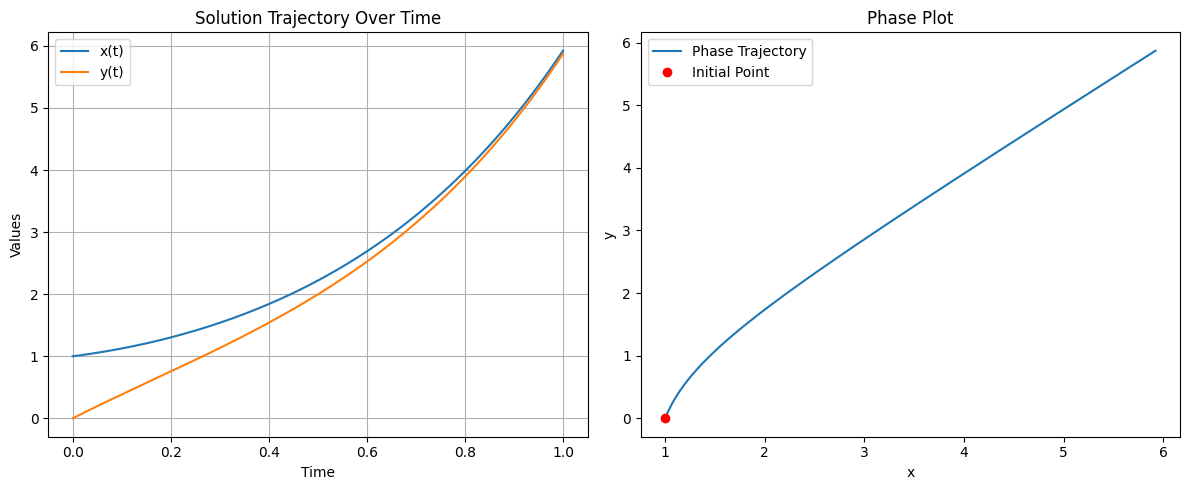

In [ ]:
# Define an initial condition
y0 = [1,0] # Initial condition for the system (at starting time t=0, [x(t)=1, y(t)=0])
params = [1,1,4,-2] # Parameters for the system

t_span = [0, 1] # Define the time span (interval) for integration
t_eval = np.linspace(t_span[0], t_span[1], 200) #create an array of points, solve_ivp computes the solutions of these points

# Solve the ODE system using solve_ivp
solution = sp.integrate.solve_ivp(rhs_2D, t_span=t_span, y0=y0, t_eval=t_eval, args=(params,))
#args=(params,) <- comma after params makes it a tuple(=list that is immutable)

# Print the solution status and shape
print("Success:", solution.success)
print("Solution shape:", solution.y.shape) #solution array (N variables * N time points)
print("First few values:\n", solution.y[:, :5])
# Plot the solution trajectory (fig, two sub plots = ...(row,colums,size))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Time series plot (plots x, then y of the solution against time)
ax1.plot(solution.t, solution.y[0], label='x(t)') #solution.y[0=dxdt of rhs_2D(1st row)]
ax1.plot(solution.t, solution.y[1], label='y(t)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.set_title('Solution Trajectory Over Time')
ax1.legend()
ax1.grid()

# Phase plot (each point (x,y) represents the state of the system at a particular time)
ax2.plot(solution.y[0], solution.y[1], label='Phase Trajectory')
ax2.plot(y0[0], y0[1], 'ro', label='Initial Point')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Phase Plot')
ax2.legend()
ax2.grid()
plt.tight_layout()

plt.legend()
plt.grid()
plt.show()

**Try this:** Change the initial conditions, _y0_, for instance [0.5,-2].

**Try this:** Go back to the original _y0=[1,0]_, integrate for a longer time, for instance change _t_span=[0,10]_, what do you see? exponential growth and instability of the system. y(t) dominated x(t).

**Try this:** Set _params=[0,1,-1,0]_, _t_span=[0,10]_, and _y0=[1,0] what happens. Rather than exponential growth, we have periodic oscillations (neutrally stable). The phase traj. moved along a closed loop (indicated center), returning to its initial state. The system is now neutrally stable. AKA has pure oscillations and a center (which means the real part of the eigen values must be 0).


## Some functions for plotting phase diagrams.
Below are utility functions to visualize the dynamics of 2D linear systems. These include:

- `plot_flow`: Plots the vector field (flow) and optionally the nullclines of the system. #nullclines are where dx/dt = 0 and dy/dt = 0.
- `plot_solution`: Integrates and plots solution trajectories for given initial conditions.
- `plot_point`: Marks fixed points or specific coordinates on the phase diagram.

These tools help illustrate the behavior of solutions, fixed points, and the overall structure of the phase space for different parameter choices.


In [ ]:

def plot_flow(ax,rhs,xrange=[-2,2],yrange=[-2,2],xnum=100,ynum=100,params=None,nullclines=False): # A function that makes a stream plot of the vector field defined by rhs
    """
    Plots the vector field (flow) of a 2D dynamical system defined by the right-hand side function `rhs`.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to plot on.
    rhs : function
        The right-hand side function of the ODE system. Should accept arguments (t, pos, params).
    xrange : list or tuple, optional
        The range of x values as [xmin, xmax]. Default is [-2, 2].
    yrange : list or tuple, optional
        The range of y values as [ymin, ymax]. Default is [-2, 2].
    xnum : int, optional
        Number of grid points in the x direction. Default is 100.
    ynum : int, optional
        Number of grid points in the y direction. Default is 100.
    params : list or array-like, optional
        Parameters to pass to the rhs function. Default is None.
    nullclines : bool, optional
        If True, plot the nullclines (where dx/dt=0 in red and dy/dt=0 in blue). Default is False.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes object with the vector field (and optionally nullclines) plotted.
    """

    u = np.linspace(xrange[0], xrange[1], xnum) # x values
    v = np.linspace(yrange[0], yrange[1], ynum) # y values
    uu, vv = np.meshgrid(u, v) # Create a meshgrid for the vector field

# Compute derivatives
    u_vel = np.empty_like(uu) # Initialize array for x derivatives
    v_vel = np.empty_like(vv)   # Initialize array for y derivatives
    for i in range(uu.shape[0]): # Loop over the grid points
        for j in range(uu.shape[1]):    # Nested loop for y direction
            u_vel[i,j], v_vel[i,j] = rhs(t=0,pos=np.array([uu[i,j], vv[i,j]]),params=params) # Evaluate rhs at each grid point

# Compute speed
    speed = np.sqrt(u_vel**2 + v_vel**2) # Calculate speed at each grid point

    # Make linewidths proportional to speed,
    # with minimal line width of 0.5 and max of 3
    lw = 0.5 + 2.5 * speed / speed.max() # Line width scaling based on speed

# Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel, linewidth=lw,color='grey') # Create the stream plot
#Nullclines
    if nullclines:  # If nullclines are requested
        ax.contour(uu, vv, u_vel, [0],colors=('r')) # Plot nullcline for u_vel=0
        ax.contour(uu, vv, v_vel, [0],colors=('b')) # Plot nullcline for v_vel=0

    return ax # Return the axis with the stream plot

# A function that plots a path
def plot_solution(ax,rhs,y0,t_end,t_dim=2000,params=None,color='green',init_pt=True,linewidth=2.5, linestyle='-'):
    """
    Integrates and plots the solution trajectory of a 2D ODE system.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to plot on.
    rhs : function
        The right-hand side function of the ODE system. Should accept arguments (t, pos, params).
    y0 : array-like
        Initial condition for the system [x0, y0].
    t_end : float
        End time for integration.
    t_dim : int, optional
        Number of time points for evaluation. Default is 2000.
    params : list or array-like, optional
        Parameters to pass to the rhs function. Default is None.
    color : str, optional
        Color of the trajectory. Default is 'green'.
    init_pt : bool, optional
        If True, marks the initial point on the plot. Default is True.
    linewidth : float, optional
        Width of the trajectory line. Default is 2.5.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes object with the solution trajectory plotted.
    """
    t = np.linspace(0, t_end, t_dim)
    X = sp.integrate.solve_ivp(rhs,t_span=[t[0],t[-1]],y0=y0,t_eval=t,args=(params,))
    x,y=X.y
    t=X.t
    ax.plot(x,y, color=color,linewidth=linewidth, linestyle=linestyle)
    if (init_pt):
        ax=plot_point(ax,y0,color=color)
    return ax

#A function to add fixed points to a phase diagram
def plot_point(ax, coord, color='black',markersize=20):
    """
    Plots a point (typically a fixed point or initial condition) on the given axes.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to plot on.
    coord : array-like
        Coordinates of the point as [x, y].
    color : str, optional
        Color of the marker face. Default is 'black'.
    markersize : int, optional
        Size of the marker. Default is 20.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes object with the point plotted.
    """
    """Add fixed points to plot."""
    x,y=coord
    ax.plot(x,y, '.', color='black', markerfacecolor=color, markersize=markersize)
    return ax



### A digression: Function Documentation and Accessing Help

In Python, functions often include documentation strings (docstrings) immediately following the function definition. These docstrings describe the purpose, parameters, and usage of the function, making the code easier to understand and maintain. For example:

```python
def my_function(x):
    """
    This function squares its input.

    Parameters
    ----------
    x : number
        The value to be squared.

    Returns
    -------
    number
        The square of x.
    """
    return x**2
```

You can access these docstrings in Jupyter Notebook using the `help()` function or a question mark (`?`) after the function name. For example:

```python
help(my_function)
```
or
```python
my_function?
```

This displays the documentation, helping users understand how to use the function without needing to read its source code. This practice is demonstrated in the notebook, where utility functions are documented and their help can be accessed interactively.

In [ ]:
help(plot_flow)

Help on function plot_flow in module __main__:

plot_flow(ax, rhs, xrange=[-2, 2], yrange=[-2, 2], xnum=100, ynum=100, params=None, nullclines=False)
    Plots the vector field (flow) of a 2D dynamical system defined by the right-hand side function `rhs`.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to plot on.
    rhs : function
        The right-hand side function of the ODE system. Should accept arguments (t, pos, params).
    xrange : list or tuple, optional
        The range of x values as [xmin, xmax]. Default is [-2, 2].
    yrange : list or tuple, optional
        The range of y values as [ymin, ymax]. Default is [-2, 2].
    xnum : int, optional
        Number of grid points in the x direction. Default is 100.
    ynum : int, optional
        Number of grid points in the y direction. Default is 100.
    params : list or array-like, optional
        Parameters to pass to the rhs function. Default is None.
    nullclines : bool, optional
 

## Our  example
This example demonstrates how to visualize the phase portrait of a two-dimensional linear system using the provided plotting utilities.
The system of equations for `params = [1, 1, 4, -2]` is:

$$
\begin{aligned}
\frac{dx}{dt} &=& x &+ y \\[3mm]
\frac{dy}{dt} &=& 4x &- 2y
\end{aligned}
$$

Classify the equilibrium point in the origin before proceeding.

In the cell below, the vector field (flow) is plotted for the system defined by the parameters `params = [1, 1, 4, -2]`, and the fixed point at the origin is marked.

By adjusting the parameters, you can explore how the system's dynamics and stability change. The plot helps illustrate the behavior of trajectories and the structure of the phase space for this particular linear system.

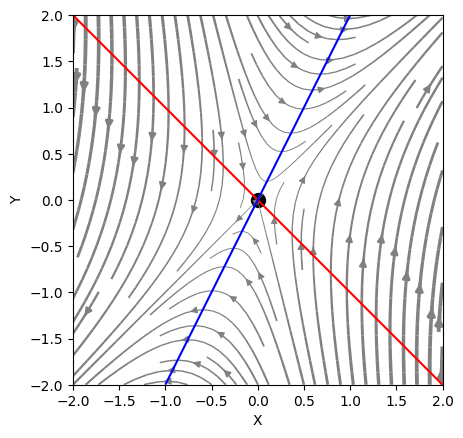

In [ ]:

params = [1,1,4,-2] # Parameters for the system
fig, ax = plt.subplots(1, 1) # Create a figure and axis for plotting
ax.set_xlabel('X')  # Label for x-axis
ax.set_ylabel('Y') # Label for y-axis
ax.set_aspect('equal') # Set equal aspect ratio

# Plot the fixed points
plot_point(ax, [0,0]) # Fixed point at the origin

# Plot the flow, change the nulclines to True to plot the nullclines
plot_flow(ax, rhs_2D, xrange=[-2, 2], yrange=[-2, 2], params=params,xnum=100, ynum=100, nullclines=True);   # Plot the vector field


**Try this:** Set _nullclines=True_ in the call to _plot_flow_. What do you see? Equilibrium points are located at the intersections of the x-nullcline and the y-nullcline.

From the graph: the origin is an unstable saddle point.

Let's add some solutions to the plot.

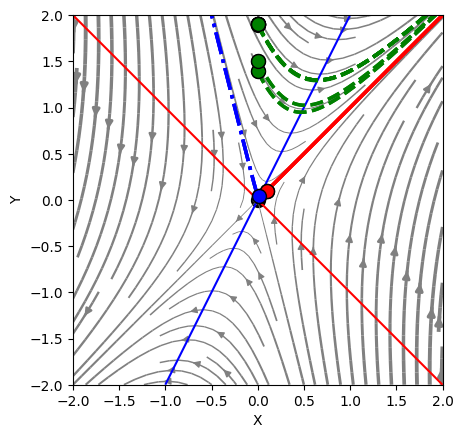

In [ ]:
# Plot solutions
y0=[0,1.9]
plot_solution(ax, rhs_2D, y0, t_end=10, t_dim=2000,params=params, color='green', init_pt=True, linewidth=2.5, linestyle='dashed')
y0=[0,1.39]
plot_solution(ax, rhs_2D, y0, t_end=10, t_dim=2000,params=params, color='green', init_pt=True, linewidth=2.5, linestyle='dashed')
y0=[0,1.5]
plot_solution(ax, rhs_2D, y0, t_end=10, t_dim=2000,params=params, color='green', init_pt=True, linewidth=2.5, linestyle='dashed')
y0=[0.1,0.1]
plot_solution(ax, rhs_2D, y0, t_end=10, t_dim=2000,params=params, color='red', init_pt=True, linewidth=2.5, linestyle='-')
y0=[0.01,0.04]
plot_solution(ax, rhs_2D, y0, t_end=-10, t_dim=2000,params=params, color='blue', init_pt=True, linewidth=2.5, linestyle='-.') # Note goes backwards in time

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()
fig



**Try this:** Add more solution curves to the plot. What do you see?

**Try this:** Uncomment the last lines in the cell above to plot two special solutions.

> **Notice** The last example, with initial conditions y0=[0.01,0.04], integrates backward in time.


# The eigenvalue problem, linear stability analysis.

Linear stability analysis investigates the behavior of solutions near equilibrium points of a dynamical system. For a linear system $\dot{\mathbf{x}} = A\mathbf{x}$, we look for solutions of the form

$$\mathbf{x}(t) = \mathbf{v} e^{\lambda t},$$

where $\mathbf{v}$ is a constant vector and $\lambda$ is a scalar. Substituting this ansatz into the differential equation leads to the eigenvalue problem:

$$
A\mathbf{v} = \lambda \mathbf{v}
$$

The eigenvalues $\lambda$ determine the growth or decay rates of solutions:  
- If $\operatorname{Re}(\lambda) < 0$, the solution decays (stable).
- If $\operatorname{Re}(\lambda) > 0$, the solution grows (unstable).
- If $\operatorname{Re}(\lambda) = 0$, the solution is neutrally stable (further analysis needed).

Thus, by finding the eigenvalues and eigenvectors of $A$, we can classify the stability and qualitative behavior of the equilibrium at the origin.
Finding the eigenvalues and eigenvectors of the matrix _A_.

The eigenvectors $\mathbf{v}$ associated with each eigenvalue $\lambda$ indicate the directions in phase space along which solutions either grow or decay exponentially. In other words, if the system starts with an initial condition aligned with an eigenvector, its trajectory will follow that direction, scaling by $e^{\lambda t}$. For real eigenvalues, these directions correspond to straight-line solutions, while for complex eigenvalues, the eigenvectors define the plane of oscillatory motion. Thus, the eigenvectors provide geometric insight into the structure of trajectories near the equilibrium point.

Using numpys eig function: https://numpy.org/doc/2.1/reference/generated/numpy.linalg.eig.html

In [ ]:
# Define the matrix A from the parameters
params = [1,1,4,-2]
A = np.array([[params[0], params[1]], [params[2], params[3]]])

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A)

pprint("A:")
pprint(A)
print()

for i in range(len(eigenvalues)):
    print(f"Eigenvalue {i+1}: {eigenvalues[i]}")
    print(f"Eigenvector {i+1}: {eigenvectors[:, i]}")
    print()

'A:'
array([[ 1,  1],
       [ 4, -2]])

Eigenvalue 1: 2.0
Eigenvector 1: [0.70710678 0.70710678]

Eigenvalue 2: -3.0
Eigenvector 2: [-0.24253563  0.9701425 ]



Since one of the e-values is >0, the system is unstable.

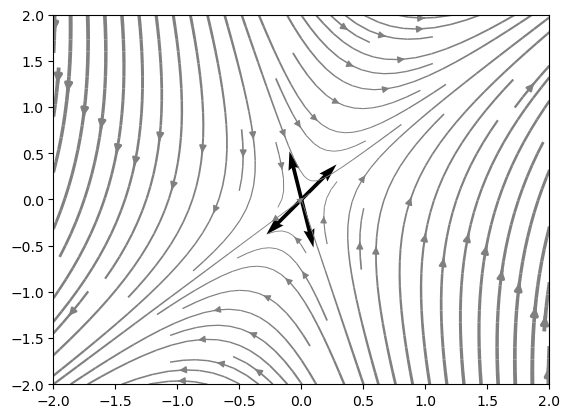

In [ ]:
# Let's plot the eigenvectors
origin = np.array([[0, 0], [0, 0]])  # origin point
fig, ax = plt.subplots(1, 1)
plot_flow(ax, rhs_2D, xrange=[-2, 2], yrange=[-2, 2], params=params,xnum=100, ynum=100, nullclines=False);   # Plot the vector field

# Plot eigenvectors
ax.quiver(*origin, eigenvectors[0, :], eigenvectors[1, :], color=['k', 'k'], scale=10)
ax.quiver(*origin, -eigenvectors[0, :], -eigenvectors[1, :], color=['k', 'k'], scale=10)
plt.show()


Let's plot the solutions starting close to the origin along the eigenvectors. The stable eigenvectors integrate backward in time.

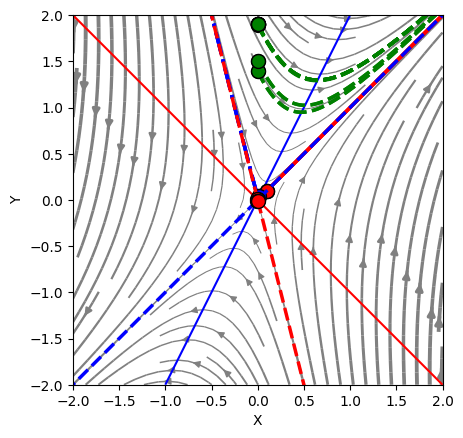

In [ ]:
# Plot solutions starting very close to the origin along the eigenvectors
for scale in [0.01, -0.01]:
    y0 = scale * eigenvectors[:, 0]
    plot_solution(ax, rhs_2D, y0, t_end=5, t_dim=2000, params=params, color='blue', init_pt=True, linewidth=2.5,linestyle='dashed')
    y0 = scale * eigenvectors[:, 1]
    plot_solution(ax, rhs_2D, y0, t_end=-10, t_dim=2000, params=params, color='red', init_pt=True, linewidth=2.5,linestyle='dashed')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()
fig


## All at once
All this in one function.

In [ ]:
def plot_phase_diagram(params, initial_points, nullclines=False, xrange=[-2,2], yrange=[-2,2], xnum=100, ynum=100, t_end=10, t_dim=2000):
    """
    Plots the phase diagram for a 2D linear system with given parameters and initial points.

    Parameters
    ----------
    params : list or array-like
        System parameters [a, b, c, d] for the equations.
    initial_points : list of lists
        List of initial conditions, each as [x0, y0].
    nullclines : bool, optional
        If True, plot the nullclines. Default is False.
    xrange, yrange : list, optional
        Ranges for x and y axes. Default is [-2, 2].
    xnum, ynum : int, optional
        Number of grid points for vector field. Default is 100.
    t_end : float, optional
        End time for integration. Default is 10.
    t_dim : int, optional
        Number of time points for evaluation. Default is 2000.
    """
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')

    plot_point(ax, [0,0])

    plot_flow(ax, rhs_2D, xrange=xrange, yrange=yrange, params=params, xnum=xnum, ynum=ynum, nullclines=nullclines)

    A = np.array([[params[0], params[1]], [params[2], params[3]]])
    eigenvalues, eigenvectors = np.linalg.eig(A)

    pprint("A:")
    pprint(A)
    print()
    for i in range(len(eigenvalues)):
        print(f"Eigenvalue {i+1}: {eigenvalues[i]}")
        print(f"Eigenvector {i+1}: {eigenvectors[:, i]}")
        print()

    origin = np.array([[0, 0], [0, 0]])
    if np.isreal(eigenvalues).all():
        ax.quiver(*origin, eigenvectors[0, :], eigenvectors[1, :], color=['k', 'k'], scale=5)
        ax.quiver(*origin, -eigenvectors[0, :], -eigenvectors[1, :], color=['k', 'k'], scale=5)
        for scale in [0.01, -0.01]:
            y0 = scale * eigenvectors[:, 0]
            plot_solution(ax, rhs_2D, y0, t_end=5, t_dim=t_dim, params=params, color='blue', init_pt=True, linewidth=2.5, linestyle='dashed')
            y0 = scale * eigenvectors[:, 1]
            plot_solution(ax, rhs_2D, y0, t_end=-10, t_dim=t_dim, params=params, color='red', init_pt=True, linewidth=2.5, linestyle='dashed')

    for y0 in initial_points:
        plot_solution(ax, rhs_2D, y0, t_end=t_end, t_dim=t_dim, params=params, color='green', init_pt=True, linewidth=2.5)

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    plt.show()
    return fig, ax



Let's run this on our example:

'A:'
array([[ 1,  1],
       [ 4, -2]])

Eigenvalue 1: 2.0
Eigenvector 1: [0.70710678 0.70710678]

Eigenvalue 2: -3.0
Eigenvector 2: [-0.24253563  0.9701425 ]



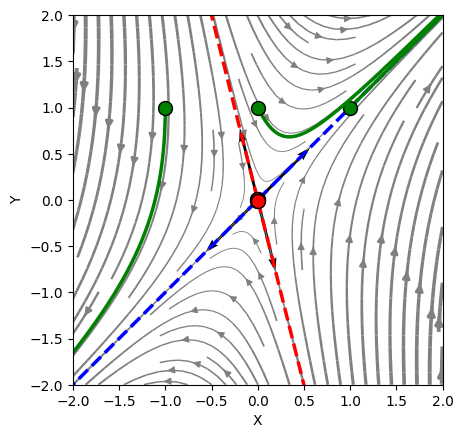

In [ ]:
params = [1,1,4,-2] # Parameters for the system
initial_points=[[-1,1],[1,1], [0,1]] # you could add more initial points here
plot_phase_diagram(params, initial_points);

# Exercises

Using pen and paper first, and then the cell above to verify your calculations, analyze the following linear systems of the form:
$$
\dot{\bf x}= A {\bf x}
$$
with:  

1.
$$
A= \left[
    \begin{matrix}
    0 & 1 \\
    1 & 0
    \end{matrix}
\right]
$$
2.  
$$
A= \left[
    \begin{matrix}
    0 & 1 \\
    -1 & 0
    \end{matrix}
\right]
$$
3.
$$
A= \left[
    \begin{matrix}
    2 & 1 \\
    3 & 4
    \end{matrix}
\right]
$$
4.  
$$
A= \left[
    \begin{matrix}
    -1 & 0 \\
    0 & -2
    \end{matrix}
\right]
$$
5.  
$$
A= \left[
    \begin{matrix}
    -1 & -2 \\
    2 & -2
    \end{matrix}
\right]
$$

6.
$$
A= \left[
    \begin{matrix}
    a & 0 \\
    0 & -1
    \end{matrix}
\right]
$$
and $a$ varies from $- \infty$ to $\infty$.

## Challenge
Can you alter the code to analyze the nonlinear problem below?
$$
\begin{align}
\dot{x}=y(1-x^2) \\
\dot{y}=-x(1-y^2)
\end{align}
$$

This problem has several equilibrium points.  
Which are (0, 0),(1, 1),(1, -1),(-1, 1),(-1, -1).


# Task
Define a new Python function, `nonlinear_rhs_2D`, to calculate the derivatives for the system `dx/dt = y(1 - x^2)` and `dy/dt = -x(1 - y^2)`. Analytically determine all equilibrium points for this nonlinear system. Then, generate a phase diagram using the `plot_flow`, `plot_point`, and `plot_solution` utilities, displaying the vector field, nullclines, equilibrium points, and several solution trajectories. Finally, summarize the observed dynamics, including the behavior around equilibrium points.

## Define Nonlinear RHS Function

### Subtask:
Create a new Python function, `nonlinear_rhs_2D`, that computes the derivatives for the given nonlinear system: `dx/dt = y(1 - x^2)` and `dy/dt = -x(1 - y^2)`. This function will mimic the structure of the `rhs_2D` function but implement the new equations.


**Reasoning**:
To define the nonlinear system as requested, I will create a new Python function `nonlinear_rhs_2D` that takes `t`, `pos`, and `params` as input and returns the derivatives `dx/dt` and `dy/dt` based on the specified nonlinear equations.



## Define Nonlinear RHS Function

### Subtask:
Create a new Python function, `nonlinear_rhs_2D`, that computes the derivatives for the given nonlinear system: `dx/dt = y(1 - x^2)` and `dy/dt = -x(1 - y^2)`. This function will mimic the structure of the `rhs_2D` function but implement the new equations.


**Reasoning**:
I will define the `nonlinear_rhs_2D` function as specified in the instructions, implementing the given nonlinear differential equations.



In [ ]:
def nonlinear_rhs_2D(t=0, pos=[0,0], params=None):
    """
    Defines the right-hand side of a 2D nonlinear ODE system:
    dx/dt = y * (1 - x^2)
    dy/dt = -x * (1 - y^2)

    Parameters
    ----------
    t : float, optional
        Time variable (not used in this autonomous system, included for compatibility).
    pos : list or array-like, optional
        Current position [x, y].
    params : unused
        Parameters are not used in this specific nonlinear system.

    Returns
    -------
    list
        Derivatives [dx/dt, dy/dt] at the given position.
    """
    x, y = pos # Unpack position into x and y

    dxdt = y * (1 - x**2)
    dydt = -x * (1 - y**2)

    return [dxdt, dydt]

print("Defined the nonlinear_rhs_2D function.")

Defined the nonlinear_rhs_2D function.


## Analytical Determination of Equilibrium Points

To find the equilibrium points of the system,
$$ \frac{dx}{dt} = y(1 - x^2) = 0 $$
$$ \frac{dy}{dt} = -x(1 - y^2) = 0 $$

we need to set both derivatives to zero and solve the resulting system of algebraic equations.

From the first equation, $y(1 - x^2) = 0$, we have two possibilities:
1. $y = 0$
2. $1 - x^2 = 0 \implies x^2 = 1 \implies x = \pm 1$

From the second equation, $-x(1 - y^2) = 0$, we have two possibilities:
1. $x = 0$
2. $1 - y^2 = 0 \implies y^2 = 1 \implies y = \pm 1$

Now, let's combine these conditions:

**Case 1: $y = 0$**
Substitute $y=0$ into the second equation: $-x(1 - 0^2) = 0 \implies -x = 0 \implies x = 0$.
This gives us the equilibrium point **(0, 0)**.

**Case 2: $x = \pm 1$**
Substitute $x=\pm 1$ into the second equation $-x(1 - y^2) = 0$. Since $x \neq 0$, we must have $1 - y^2 = 0 \implies y = \pm 1$.
This gives us four equilibrium points:
* For $x = 1$:
    * $(1, 1)$
    * $(1, -1)$
* For $x = -1$:
    * $(-1, 1)$
    * $(-1, -1)$

Combining all these results, the equilibrium points for the nonlinear system are:
* **(0, 0)**
* **(1, 1)**
* **(1, -1)**
* **(-1, 1)**
* **(-1, -1)**

These are the points where the system is at rest, meaning that if a trajectory starts at any of these points, it will remain there indefinitely.

**Reasoning**:
The analytical determination of equilibrium points is complete. The next step is to generate the phase diagram using the utility functions. This involves initializing the plot, defining parameters and plotting ranges, and then plotting the vector field with nullclines, marking all equilibrium points, and adding some solution trajectories.



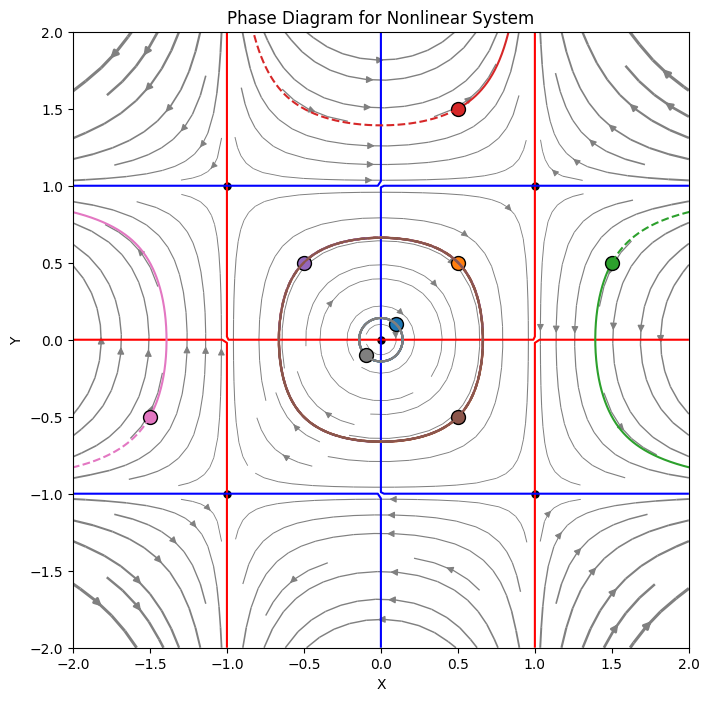

Generated the phase diagram for the nonlinear system.


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Phase Diagram for Nonlinear System')
ax.set_aspect('equal')

xrange = [-2, 2]
yrange = [-2, 2]

# Plot the equilibrium points
equilibrium_points = [[0, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]]
for point in equilibrium_points:
    plot_point(ax, point, color='black', markersize=10)

# Plot the flow and nullclines
plot_flow(ax, nonlinear_rhs_2D, xrange=xrange, yrange=yrange, xnum=100, ynum=100, params=None, nullclines=True)

# Define some initial conditions for trajectories
initial_conditions = [
    [0.1, 0.1],    # Near origin
    [0.5, 0.5],    # Within a cell
    [1.5, 0.5],    # Near (1,1)
    [0.5, 1.5],    # Near (1,1)
    [-0.5, 0.5],   # Near (-1,1)
    [0.5, -0.5],   # Near (1,-1)
    [-1.5, -0.5],  # Near (-1,-1)
    [-0.1, -0.1]   # Near origin
]

# Plot solution trajectories
for i, y0 in enumerate(initial_conditions):
    # Forward in time
    plot_solution(ax, nonlinear_rhs_2D, y0, t_end=10, t_dim=2000, params=None, color=f'C{i}', init_pt=True, linewidth=1.5)
    # Backward in time for some to show full trajectories
    plot_solution(ax, nonlinear_rhs_2D, y0, t_end=-10, t_dim=2000, params=None, color=f'C{i}', init_pt=False, linewidth=1.5, linestyle='--')

ax.set_xlim(xrange)
ax.set_ylim(yrange)
plt.show()
print("Generated the phase diagram for the nonlinear system.")

## Summary of Observed Dynamics

From the generated phase diagram, we can observe the following dynamics for the nonlinear system:

*   **Equilibrium Points**: We identified five equilibrium points:
    *   **(0, 0)**: This point appears to be a **saddle point**. Trajectories approach it along certain directions (stable manifolds) and move away along others (unstable manifolds). The nullclines (red for dx/dt=0, blue for dy/dt=0) intersect at this point, as expected.
    *   **(1, 1), (1, -1), (-1, 1), (-1, -1)**: These four points appear to be **centers** (or possibly spirals with very weak damping, though the trajectories look like closed orbits). Trajectories around these points form closed loops, indicating periodic oscillations. This suggests that the real part of the eigenvalues of the linearized system at these points might be zero, leading to neutrally stable oscillations.

*   **Vector Field and Trajectories**: The streamplot (vector field) clearly shows the direction of flow. Trajectories generally move away from the saddle point at the origin and orbit around the four corner equilibrium points. The nullclines help to delineate regions where either x or y is constant, and their intersections mark the equilibrium points.

*   **Global Behavior**: The system exhibits complex dynamics with multiple stable oscillatory regions and an unstable saddle point. Trajectories initiated near the origin tend to move towards the regions surrounding the centers, demonstrating a basin of attraction for these oscillatory behaviors.

The phase diagram effectively visualizes the system's stability and long-term behavior for different initial conditions, confirming the analytical findings for the equilibrium points and providing insight into their qualitative nature.

## Summary of Observed Dynamics

From the generated phase diagram, we can observe the following dynamics for the nonlinear system:

*   **Equilibrium Points**: We identified five equilibrium points:
    *   **(0, 0)**: This point appears to be a **saddle point**. Trajectories approach it along certain directions (stable manifolds) and move away along others (unstable manifolds). The nullclines (red for dx/dt=0, blue for dy/dt=0) intersect at this point, as expected.
    *   **(1, 1), (1, -1), (-1, 1), (-1, -1)**: These four points appear to be **centers** (or possibly spirals with very weak damping, though the trajectories look like closed orbits). Trajectories around these points form closed loops, indicating periodic oscillations. This suggests that the real part of the eigenvalues of the linearized system at these points might be zero, leading to neutrally stable oscillations.

*   **Vector Field and Trajectories**: The streamplot (vector field) clearly shows the direction of flow. Trajectories generally move away from the saddle point at the origin and orbit around the four corner equilibrium points. The nullclines help to delineate regions where either x or y is constant, and their intersections mark the equilibrium points.

*   **Global Behavior**: The system exhibits complex dynamics with multiple stable oscillatory regions and an unstable saddle point. Trajectories initiated near the origin tend to move towards the regions surrounding the centers, demonstrating a basin of attraction for these oscillatory behaviors.

The phase diagram effectively visualizes the system's stability and long-term behavior for different initial conditions, confirming the analytical findings for the equilibrium points and providing insight into their qualitative nature.

## Final Task

### Subtask:
Summarize the analysis of the nonlinear phase diagram, including observations about the equilibrium points, nullclines, and trajectory behaviors.


## Summary:

### Q&A
The analysis of the nonlinear phase diagram reveals the following dynamics:
*   **Equilibrium Points**: Five equilibrium points were identified:
    *   **(0, 0)**: This point behaves as a **saddle point**. Trajectories approach it along specific directions and diverge along others. Its location is confirmed by the intersection of the nullclines.
    *   **(1, 1), (1, -1), (-1, 1), (-1, -1)**: These four points act as **centers**. Trajectories around these points form closed loops, indicating periodic oscillations. This suggests a neutrally stable behavior where trajectories remain in a closed orbit.
*   **Nullclines**: The red nullclines (where $\frac{dx}{dt}=0$) and blue nullclines (where $\frac{dy}{dt}=0$) clearly mark regions where either the x or y component of the velocity vector is zero. Their intersections precisely correspond to the analytically determined equilibrium points.
*   **Trajectory Behaviors**: The vector field illustrates the flow direction across the phase space. Trajectories initiated near the origin tend to move away from the saddle point at (0, 0) and are attracted to the oscillatory regions surrounding the four center points. This demonstrates a global behavior where the system tends towards periodic oscillations after escaping the influence of the saddle.

### Data Analysis Key Findings
*   A new Python function, `nonlinear_rhs_2D`, was successfully defined to model the system $\frac{dx}{dt} = y(1 - x^2)$ and $\frac{dy}{dt} = -x(1 - y^2)$.
*   Analytically, five equilibrium points were identified for the system: $(0, 0)$, $(1, 1)$, $(1, -1)$, $(-1, 1)$, and $(-1, -1)$.
*   The phase diagram visually confirmed these equilibrium points and their qualitative stability types:
    *   The point $(0, 0)$ behaves as a **saddle point**.
    *   The points $(1, 1)$, $(1, -1)$, $(-1, 1)$, and $(-1, -1)$ appear to be **centers**, characterized by closed-loop trajectories around them, indicating periodic oscillations.
*   The nullclines intersect precisely at the identified equilibrium points, providing a visual confirmation of their analytical derivation.
*   The global behavior of the system shows trajectories moving away from the saddle point and orbiting around the four centers, indicating stable oscillatory regions.

### Insights or Next Steps
*   Linearize the system around each equilibrium point to analytically confirm the classification (saddle, center) and determine the eigenvalues to rigorously prove their stability types.
*   Explore the basins of attraction for the observed oscillatory behaviors more quantitatively to understand the initial conditions that lead to these periodic trajectories.
